In [1]:
import numpy as np
freq_bands = dict(                #the frequency bands of interest for the analysis
                delta=(1, 4), 
                theta=(4, 8), 
                alpha=(8, 12), 
                beta=(13, 29), 
                gamma=(30, 80))

In [2]:
log_freq_bands = dict()

In [15]:
for band in freq_bands:
    lower, upper = freq_bands[band]
    band_range = upper - lower +1
    log_freq_bands[band] = (np.logspace(np.log10(lower), np.log10(upper), band_range))

In [16]:
log_freq_bands

{'delta': array([1.        , 1.58740105, 2.5198421 , 4.        ]),
 'theta': array([5.        , 5.91607978, 7.        ]),
 'alpha': array([ 8.        ,  8.85345536,  9.79795897, 10.84322404, 12.        ]),
 'beta': array([13.        , 13.66852866, 14.37143659, 15.11049176, 15.88755305,
        16.70457494, 17.5636124 , 18.46682611, 19.41648784, 20.41498619,
        21.4648326 , 22.56866765, 23.72926774, 24.94955201, 26.23258974,
        27.58160805, 29.        ]),
 'gamma': array([30.        , 30.59430764, 31.20038866, 31.8184763 , 32.44880842,
        33.09162757, 33.74718114, 34.41572139, 35.09750559, 35.79279611,
        36.50186051, 37.22497166, 37.96240783, 38.71445279, 39.48139596,
        40.26353246, 41.06116329, 41.87459539, 42.70414178, 43.5501217 ,
        44.4128607 , 45.29269078, 46.18995051, 47.10498519, 48.03814694,
        48.98979486, 49.96029516, 50.95002133, 51.95935422, 52.98868226,
        54.03840154, 55.10891603, 56.20063769, 57.31398663, 58.44939129,
        59.

In [1]:
import mne
rawfile = "/home/idrael/DATA/MEG/BIDS_clinic/derivatives/sub-BF28011991/meg/BF28011991_Block1_trans_tsss-eve-epo.fif"
epochs = mne.read_epochs(rawfile, preload= True)

Reading /home/idrael/DATA/MEG/BIDS_clinic/derivatives/sub-BF28011991/meg/BF28011991_Block1_trans_tsss-eve-epo.fif ...
    Found the data of interest:
        t =   -2000.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
11 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


In [3]:
events = epochs.event_id
events

{'ignore_me': 0, 'AAA': 1, 'Gr_1': 2, 'Gr_2': 3}

In [4]:
gr_1 = epochs["Gr_1"].load_data().average

In [8]:
for event in events.keys():
    print(event)

ignore_me
AAA
Gr_1
Gr_2


# Dipole visualization

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from configuration import (subjects, n_jobs, bids_root, use_source_model_for_sourceloc, inv_loose_option,
                            use_fwd_model_for_sourceloc, do_volume_source_loc, source_loc_methods,
                            pick_meg, pick_eeg, concat_raws, signal_to_noise_ratio, minimum_norm_ori,
                            peaks_tmin, peaks_tmax, peaks_mode, peaks_nr_of_points, dip_times)
import mne
from utils.utils import FileNameRetriever, RawPreprocessor, get_peak_points
import glob
from nilearn.plotting import plot_anat

mne.viz.set_3d_backend("pyvista")

fnr =FileNameRetriever(bids_root)
prepper = RawPreprocessor()

snr = signal_to_noise_ratio
lambda2 = 1. / snr ** 2

for subj in subjects:
    meg_folder = fnr.get_filename(subj, "meg")
    epos = glob.glob(meg_folder + "/*epo.fif")
    subjects_dir = fnr.get_filename(subj=subj, file="subjects_dir")
    bem_sol = fnr.get_filename(subj=subj, file=use_fwd_model_for_sourceloc)
    trans_file = fnr.get_single_trans_file(subj)
    for epo in epos:
        epochs = mne.read_epochs(epo)
        print(f"Event-IDs are: {epochs.event_id}")
        events = epochs.event_id
        print(f"\n\n\nevents: {events}")

        noise_cov = mne.compute_covariance(epochs, tmax=-1, 
                                    #projs=, 
                                    method='auto',
                                    n_jobs=n_jobs)

        data_cov = mne.compute_covariance(epochs,
                                    tmin=-0.5, 
                                    tmax=0.3, 
                                    #projs=, 
                                    method='auto',
                                    n_jobs=n_jobs)

        for event in events.keys():
            eventname = str(event)
            if eventname == "ignore_me" or eventname == "AAA":
                pass
            else:
                e = epochs[eventname].load_data().average()
                spike_folder = fnr.get_filename(subj, "spikes")
                e_folder = os.path.join(spike_folder, eventname)
                cp_folder = os.path.join(spike_folder, eventname, "custom_pics")
                cts_folder = os.path.join(spike_folder, eventname, "custom_time_series")
                gp_folder = os.path.join(spike_folder, eventname, "generic_pics")
                folders = [e_folder, cp_folder, cts_folder, gp_folder]
                if not os.path.isdir(e_folder):
                    for f in folders:
                        print(f)
                        os.mkdir(f)
                
                src_file = fnr.get_filename(subj, use_source_model_for_sourceloc)
                if os.path.isfile(src_file):
                    src = mne.read_source_spaces(src_file)
                else:
                    src = mne.setup_source_space(subj, spacing = use_source_model_for_sourceloc, 
                                                subjects_dir = subjects_dir, 
                                                n_jobs=n_jobs, 
                                                verbose=True)

                fwd = mne.make_forward_solution(e.info, src=src, bem=bem_sol,
                                            trans=trans_file, 
                                            meg=pick_meg, eeg=pick_eeg, mindist=0.2, 
                                            ignore_ref=False, 
                                            n_jobs=n_jobs, verbose=True)
                             
                inv = mne.minimum_norm.make_inverse_operator(e.info, forward=fwd, noise_cov=noise_cov, 
                                            loose=inv_loose_option, depth=0.8)
    

            

Using pyvista 3d backend.

Reading /home/idrael/DATA/MEG/BIDS_clinic/derivatives/sub-KV08082000/meg/KV08082000_block02_trans_tsss-eve-epo.fif ...
    Found the data of interest:
        t =   -1500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
26 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Event-IDs are: {'ignore_me': 0, 'AAA': 1, 'Gr_1_re': 2, 'Gr_2_re': 3, 'Gr_3_li': 4}



events: {'ignore_me': 0, 'AAA': 1, 'Gr_1_re': 2, 'Gr_2_re': 3, 'Gr_3_li': 4}
Computing rank from data with rank=None
    Using tolerance 9.9e-09 (2.2e-16 eps * 306 dim * 1.5e+05  max singular value)
    Estimated rank (mag + grad): 306
    MEG: rank 306 computed from 306 data channels with 0 projectors
    Using tolerance 6.9e-11 (2.2e-16 eps * 64 dim * 4.9e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 370 ->

<ipython-input-1-57e9b8e8c3dc>:33: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  noise_cov = mne.compute_covariance(epochs, tmax=-1,


Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
    GRAD regularization : 0.1
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 3926
log-likelihood on unseen data (descending order):
   shrunk: -866.061
   diagonal_fixed: -1741.032
   empirical: -3922.045
selecting best estimator: shrunk
[done]
Computing rank from data with rank=None
    Using tolerance 1.4e-08 (2.2e-16 eps * 306 dim * 2e+05  max singular value)
    Estimated rank (mag + grad): 306
    MEG: rank 306 computed from 306 data channels with 0 projectors
    Using tolerance 1e-10 (2.2e-16 eps * 64 dim * 7.1e+03  max singular value)
    Estimated rank (eeg): 64
    EEG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 370 -> 370
Estimating covariance using SHRUNK


<ipython-input-1-57e9b8e8c3dc>:38: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  data_cov = mne.compute_covariance(epochs,


Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
    GRAD regularization : 0.1
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
Number of samples used : 6266
log-likelihood on unseen data (descending order):
   shrunk: -931.401
   diagonal_fixed: -1795.947
   empirical: -3992.756
selecting best estimator: shrunk
[done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Source space          : <SourceSpaces: [<surface (lh), n_vertices=132696, n_used=2562>, <surface (rh), n_vertices=129261, n_used=2562>] MRI (surface RAS) coords, subject 'KV08082000'>
MRI -> head transform : /home/idrael/DATA/MEG/BIDS_clinic/derivatives/sub-KV08

[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:   10.2s remaining:   29.5s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:   10.4s remaining:   11.0s


    Skipping interior check for 950 sources that fit inside a sphere of radius   49.9 mm
    Skipping solid angle check for 0 points using Qhull


[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:   10.5s remaining:    4.2s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:   10.5s remaining:    0.6s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:   10.6s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.1s remaining:    0.0s



Setting up compensation data...
    No compensation set. Nothing more to do.

Composing the field computation matrix...


[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.1s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    7.9s remaining:   22.8s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    8.1s remaining:    8.6s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    8.2s remaining:    3.3s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    8.2s remaining:    0.5s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    8.4s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.5s remaining:    1.4s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:   

Computing MEG at 5124 source locations (free orientations)...


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.1s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    1.2s remaining:    3.3s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    1.8s remaining:    1.9s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    2.5s remaining:    1.0s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    3.2s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    3.4s finished



Finished.


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.1s finished


Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 3681/5124 = 10.002070
    scale = 3.01203e-07 exp = 0.8
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 4.2e-12 (2.2e-16 eps * 306 dim * 62  max singular value)
    Estimated rank (mag + grad): 306
    MEG: rank 306 computed from 306 data channels with 0 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 5.86143
    scaling factor to adjust the trace = 4.34684e+21


<ipython-input-1-57e9b8e8c3dc>:77: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(e.info, forward=fwd, noise_cov=noise_cov,
<ipython-input-1-57e9b8e8c3dc>:77: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(e.info, forward=fwd, noise_cov=noise_cov,


    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Source space          : <SourceSpaces: [<surface (lh), n_vertices=132696, n_used=2562>, <surface (rh), n_vertices=129261, n_used=2562>] MRI (surface RAS) coords, subject 'KV08082000'>
MRI -> head transform : /home/idrael/DATA/MEG/BIDS_clinic/derivatives/sub-KV08082000/meg/KV08082000-transfile.fif
Measurement data      : instance of Info
Conductor model   : /home/idrael/DATA/MEG/BIDS_clinic/derivatives/sub-KV08082000/forward_model/KV08082000-3-layer-BEM-solution.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 5124 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.995503  0.082

[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.1s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.1s finished



Setting up compensation data...
    No compensation set. Nothing more to do.

Composing the field computation matrix...


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.5s remaining:    1.6s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.6s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.5s remaining:    1.3s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.6s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35

Computing MEG at 5124 source locations (free orientations)...


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.1s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    1.2s remaining:    3.5s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    2.1s remaining:    2.3s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    3.1s remaining:    1.2s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    3.9s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    4.1s finished



Finished.


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.1s finished


Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 3681/5124 = 10.002070
    scale = 3.01203e-07 exp = 0.8
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 4.2e-12 (2.2e-16 eps * 306 dim * 62  max singular value)
    Estimated rank (mag + grad): 306
    MEG: rank 306 computed from 306 data channels with 0 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 5.86143
    scaling factor to adjust the trace = 4.34684e+21


<ipython-input-1-57e9b8e8c3dc>:77: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(e.info, forward=fwd, noise_cov=noise_cov,
<ipython-input-1-57e9b8e8c3dc>:77: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(e.info, forward=fwd, noise_cov=noise_cov,


    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Source space          : <SourceSpaces: [<surface (lh), n_vertices=132696, n_used=2562>, <surface (rh), n_vertices=129261, n_used=2562>] MRI (surface RAS) coords, subject 'KV08082000'>
MRI -> head transform : /home/idrael/DATA/MEG/BIDS_clinic/derivatives/sub-KV08082000/meg/KV08082000-transfile.fif
Measurement data      : instance of Info
Conductor model   : /home/idrael/DATA/MEG/BIDS_clinic/derivatives/sub-KV08082000/forward_model/KV08082000-3-layer-BEM-solution.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Read 2 source spaces a total of 5124 active source locations

Coordinate transformation: MRI (surface RAS) -> head
     0.995503  0.082

[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.1s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.1s finished



Setting up compensation data...
    No compensation set. Nothing more to do.

Composing the field computation matrix...


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.6s remaining:    1.6s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.6s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.4s remaining:    1.3s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.6s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35

Computing MEG at 5124 source locations (free orientations)...


[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.1s finished
[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    1.3s remaining:    3.7s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    2.2s remaining:    2.4s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    3.2s remaining:    1.3s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    4.1s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    4.3s finished



Finished.


[Parallel(n_jobs=35)]: Using backend LokyBackend with 35 concurrent workers.
[Parallel(n_jobs=35)]: Done   9 out of  35 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=35)]: Done  17 out of  35 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=35)]: Done  25 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  33 out of  35 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=35)]: Done  35 out of  35 | elapsed:    0.1s finished


Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 3681/5124 = 10.002070
    scale = 3.01203e-07 exp = 0.8
Whitening the forward solution.
Computing rank from covariance with rank=None
    Using tolerance 4.2e-12 (2.2e-16 eps * 306 dim * 62  max singular value)
    Estimated rank (mag + grad): 306
    MEG: rank 306 computed from 306 data channels with 0 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.


<ipython-input-1-57e9b8e8c3dc>:77: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(e.info, forward=fwd, noise_cov=noise_cov,
<ipython-input-1-57e9b8e8c3dc>:77: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(e.info, forward=fwd, noise_cov=noise_cov,


    largest singular value = 5.86143
    scaling factor to adjust the trace = 4.34684e+21


MRI transform     : /home/idrael/DATA/MEG/BIDS_clinic/derivatives/sub-KV08082000/meg/KV08082000-transfile.fif
Head origin       :   -1.1   -2.2   58.5 mm rad =   72.4 mm.
Guess grid        :   20.0 mm
Guess mindist     :    5.0 mm
Guess exclude     :   20.0 mm
Using standard MEG coil definitions.

Coordinate transformation: MRI (surface RAS) -> head
     0.995503  0.082201  0.047082      -3.31 mm
    -0.091585  0.962161  0.256630      15.46 mm
    -0.024205 -0.259788  0.965362      23.03 mm
     0.000000  0.000000  0.000000       1.00
Coordinate transformation: MEG device -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
     0.000000  0.000000  1.000000      40.00 mm
     0.000000  0.000000  0.000000       1.00
0 bad channels total
Read 306 MEG channels from info
99 coil definitions read
Coordinate transformation: MEG device -> head
     1.000000  0.000000  0.000000       0.00 mm
     0.000000  1.000000  0.000000       0.00 mm
    

<ipython-input-15-2161fc2e75ce>:6: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (306 > 70). Consider setting rank to "auto" or setting it explicitly as an integer.
  ecd = mne.fit_dipole(dip_epoch, noise_cov, bem_sol, trans=trans_file)[0]


    235 source space points omitted because they are outside the inner skull surface.
    33 source space points omitted because of the    5.0-mm distance limit.
166 sources remaining after excluding the sources outside the surface and less than    5.0 mm inside.
Go through all guess source locations...
[done 166 sources]
---- Fitted :   -26.7 ms, distance to inner skull : 6.6925 mm
---- Fitted :   -23.3 ms, distance to inner skull : 5.0005 mm
---- Fitted :   -20.0 ms, distance to inner skull : 5.0010 mm
No projector specified for this dataset. Please consider the method self.add_proj.
3 time points fitted


AttributeError: 'numpy.ndarray' object has no attribute 'axis'

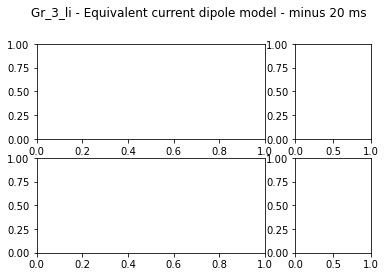

<Figure size 475.2x187.2 with 0 Axes>

In [15]:
for m in source_loc_methods:
    stc_name = "stc_" + m + "_" + eventname
    stc_name = 'stc_' + m
    for start, stop in dip_times.values():
        dip_epoch = e.copy().crop(start, stop).pick('meg')
        ecd = mne.fit_dipole(dip_epoch, noise_cov, bem_sol, trans=trans_file)[0]
        best_idx = np.argmax(ecd.gof)
        best_time = ecd.times[best_idx]
        trans = mne.read_trans(trans_file)
        mri_pos = mne.head_to_mri(ecd.pos, mri_head_t=trans, subject=subj, subjects_dir=subjects_dir)
        t1_file_name = os.path.join(subjects_dir, subj, 'mri', 'T1.mgz')
        stoptime = str(abs(int(stop*1000)))
        if stoptime == "5":
            stoptime = "05"
        title = str(eventname + ' - ECD @ minus ' + stoptime + ' ms')

        # visualization
        
        fig, axes = plt.subplots(nrows=2, ncols=2,
                                    gridspec_kw=dict(width_ratios=[3, 1],
                                    top=0.85))
        fig.suptitle(f"{eventname} - Equivalent current dipole model - minus {stoptime} ms")
        plot_anat(t1_file_name, cut_coords=mri_pos[0], axes=axes[0])
        fig.add_subplot(2,2,1, projection="3d")
        ecd.plot_locations(trans, subj, subjects_dir, mode="orthoview")
        t1_f_name_pic = ('img_ecd_' + eventname + '_' + '_Dipol_' + stoptime + '.png')
        t1_f_name_pic = os.path.join(e_folder, t1_f_name_pic)
        fig.savefig(t1_f_name_pic)
        plt.close("all")